In [5]:
# Step 1: Setup and reproducibility
# - Import required libraries
# - Set random seeds for reproducibility
# - Detect GPU/CPU device
import os
import math
import random
import time
from typing import Optional

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as T
from tqdm import tqdm

def seed_everything(seed=42, deterministic=False):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    else:
        torch.backends.cudnn.benchmark = True

seed_everything(42, deterministic=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [6]:
# Step 2: Prepare CIFAR-10 dataset
# - Define normalization statistics
# - Apply data augmentation for training
# - Split into train/val/test sets
# - Create dataloaders
MEAN = (0.4914, 0.4822, 0.4465)
STD  = (0.2023, 0.1994, 0.2010)

train_transform = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(MEAN, STD),
])

test_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(MEAN, STD),
])

root = "./data"
full_train = torchvision.datasets.CIFAR10(root=root, train=True, download=True, transform=train_transform)
test_set   = torchvision.datasets.CIFAR10(root=root, train=False, download=True, transform=test_transform)

val_size = 5000
train_size = len(full_train) - val_size
train_set, val_set = random_split(full_train, [train_size, val_size])

batch_size = 128
num_workers = 2
pin_memory = True if device.type == "cuda" else False

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,  num_workers=num_workers, pin_memory=pin_memory)
val_loader   = DataLoader(val_set,   batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)


In [7]:
# Step 3: Define the Vision Transformer (ViT) model
# - Patch embedding layer
# - Transformer encoder blocks (MHSA + MLP)
# - CLS token and positional embeddings
# - Final classification head
class PatchEmbed(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3, embed_dim=192):
        super().__init__()
        assert img_size % patch_size == 0
        self.num_patches = (img_size // patch_size) * (img_size // patch_size)
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)
        return x.flatten(2).transpose(1, 2)

class DropPath(nn.Module):
    def __init__(self, drop_prob=0.0): super().__init__(); self.drop_prob = drop_prob
    def forward(self, x):
        if self.drop_prob == 0. or not self.training: return x
        keep_prob = 1 - self.drop_prob
        shape = (x.size(0),) + (1,) * (x.dim() - 1)
        random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
        random_tensor.floor_()
        return x.div(keep_prob) * random_tensor

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, dim, num_heads=3, qkv_bias=True, attn_drop=0., proj_drop=0.):
        super().__init__()
        assert dim % num_heads == 0
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2,0,3,1,4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1); attn = self.attn_drop(attn)
        out = (attn @ v).transpose(1, 2).reshape(B, N, C)
        return self.proj_drop(self.proj(out))

class MLP(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features * 4
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)
    def forward(self, x):
        return self.drop(self.fc2(self.drop(self.act(self.fc1(x)))))

class TransformerEncoderBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=True, drop=0., attn_drop=0., drop_path=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = MultiHeadSelfAttention(dim, num_heads, qkv_bias, attn_drop, drop)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(dim, int(dim*mlp_ratio), drop=drop)
    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        return x + self.drop_path(self.mlp(self.norm2(x)))

class VisionTransformer(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3, num_classes=10,
                 embed_dim=192, depth=8, num_heads=3, mlp_ratio=4.,
                 qkv_bias=True, drop_rate=0.0, attn_drop_rate=0.0, drop_path_rate=0.1):
        super().__init__()
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(drop_rate)
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]
        self.blocks = nn.ModuleList([
            TransformerEncoderBlock(embed_dim, num_heads, mlp_ratio, qkv_bias,
                                    drop_rate, attn_drop_rate, dpr[i]) for i in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.head.weight, std=0.02)
        nn.init.zeros_(self.head.bias)
    def forward(self, x):
        B = x.size(0)
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1) + self.pos_embed
        x = self.pos_drop(x)
        for blk in self.blocks: x = blk(x)
        x = self.norm(x)
        return self.head(x[:, 0])


In [8]:
# Step 4: Define training components
# - Instantiate ViT model
# - Define loss function (label smoothing)
# - Optimizer (AdamW)
# - Learning rate scheduler (cosine annealing)
# - Gradient scaler (mixed precision)
model = VisionTransformer(img_size=32, patch_size=4, embed_dim=192,
                          depth=8, num_heads=3, mlp_ratio=4.,
                          drop_rate=0.1, attn_drop_rate=0.1, drop_path_rate=0.1).to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.05)
epochs = 50
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
scaler = torch.amp.GradScaler()


In [9]:
# Step 5: (Optional) Warmup Scheduler
class WarmupScheduler:
    def __init__(self, optimizer, base_scheduler, warmup_epochs=0, total_epochs=epochs):
        self.optimizer = optimizer
        self.base = base_scheduler
        self.warmup_epochs = warmup_epochs
        self.total_epochs = total_epochs
        self.last_epoch = 0
    def step(self):
        self.last_epoch += 1
        if self.warmup_epochs > 0 and self.last_epoch <= self.warmup_epochs:
            factor = self.last_epoch / float(self.warmup_epochs)
            for g in self.optimizer.param_groups:
                g['lr'] = g.get('initial_lr', g['lr']) * factor
        else:
            self.base.step()

warmup_epochs = 0
for g in optimizer.param_groups:
    g.setdefault('initial_lr', g['lr'])
scheduler_wrapped = WarmupScheduler(optimizer, scheduler, warmup_epochs)


In [10]:
# Step 6: Training and evaluation helper functions
def train_one_epoch(epoch):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    pbar = tqdm(train_loader, desc=f"Train Ep {epoch}", leave=False)
    for imgs, targets in pbar:
        imgs, targets = imgs.to(device), targets.to(device)
        optimizer.zero_grad()
        with torch.amp.autocast(device_type=device.type):
            logits = model(imgs)
            loss = criterion(logits, targets)
        scaler.scale(loss).backward()
        scaler.step(optimizer); scaler.update()
        running_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == targets).sum().item(); total += targets.size(0)
        pbar.set_postfix(dict(loss=running_loss/total, acc=100.0*correct/total))
    scheduler_wrapped.step()
    return running_loss/total, 100.0*correct/total

@torch.no_grad()
def evaluate(loader):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    for imgs, targets in loader:
        imgs, targets = imgs.to(device), targets.to(device)
        with torch.amp.autocast(device_type=device.type):
            logits = model(imgs)
            loss = criterion(logits, targets)
        running_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == targets).sum().item(); total += targets.size(0)
    return running_loss/total, 100.0*correct/total


In [11]:
# Step 7: Training loop with checkpointing
best_val_acc = 0.0
save_path = "best_vit_cifar10.pth"

for epoch in range(1, epochs + 1):
    t0 = time.time()
    train_loss, train_acc = train_one_epoch(epoch)
    val_loss, val_acc = evaluate(val_loader)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "scaler_state": scaler.state_dict(),
            "best_val_acc": best_val_acc,
        }, save_path)
    lr = optimizer.param_groups[0]['lr']
    print(f"[{epoch:02d}/{epochs:02d}] Train loss: {train_loss:.4f}, Train acc: {train_acc:.2f}% | "
          f"Val loss: {val_loss:.4f}, Val acc: {val_acc:.2f}% | LR: {lr:.2e} | time: {time.time()-t0:.1f}s")


[01/50] Train loss: 1.9093, Train acc: 32.30% | Val loss: 1.7818, Val acc: 40.26% | LR: 3.00e-04 | time: 28.8s


[02/50] Train loss: 1.7062, Train acc: 43.49% | Val loss: 1.6356, Val acc: 47.26% | LR: 2.99e-04 | time: 28.5s


[03/50] Train loss: 1.5903, Train acc: 49.11% | Val loss: 1.4897, Val acc: 53.86% | LR: 2.97e-04 | time: 27.6s


[04/50] Train loss: 1.5092, Train acc: 53.33% | Val loss: 1.4569, Val acc: 55.80% | LR: 2.95e-04 | time: 27.5s


[05/50] Train loss: 1.4480, Train acc: 56.15% | Val loss: 1.3853, Val acc: 59.42% | LR: 2.93e-04 | time: 28.6s


[06/50] Train loss: 1.3964, Train acc: 58.77% | Val loss: 1.3608, Val acc: 59.74% | LR: 2.89e-04 | time: 27.5s


[07/50] Train loss: 1.3610, Train acc: 60.20% | Val loss: 1.3245, Val acc: 62.52% | LR: 2.86e-04 | time: 28.5s


[08/50] Train loss: 1.3190, Train acc: 62.55% | Val loss: 1.2952, Val acc: 63.60% | LR: 2.81e-04 | time: 27.5s


[09/50] Train loss: 1.2860, Train acc: 64.12% | Val loss: 1.2797, Val acc: 64.12% | LR: 2.77e-04 | time: 27.5s


[10/50] Train loss: 1.2588, Train acc: 65.24% | Val loss: 1.2563, Val acc: 65.18% | LR: 2.71e-04 | time: 27.5s


[11/50] Train loss: 1.2354, Train acc: 66.51% | Val loss: 1.2233, Val acc: 66.40% | LR: 2.66e-04 | time: 27.7s


[12/50] Train loss: 1.2046, Train acc: 67.92% | Val loss: 1.2113, Val acc: 67.50% | LR: 2.59e-04 | time: 28.4s


[13/50] Train loss: 1.1875, Train acc: 68.33% | Val loss: 1.1753, Val acc: 70.18% | LR: 2.53e-04 | time: 28.6s


[14/50] Train loss: 1.1678, Train acc: 69.71% | Val loss: 1.1869, Val acc: 69.34% | LR: 2.46e-04 | time: 27.6s


[15/50] Train loss: 1.1459, Train acc: 70.50% | Val loss: 1.1278, Val acc: 72.10% | LR: 2.38e-04 | time: 27.5s


[16/50] Train loss: 1.1278, Train acc: 71.53% | Val loss: 1.1116, Val acc: 72.06% | LR: 2.30e-04 | time: 27.4s


[17/50] Train loss: 1.1093, Train acc: 72.36% | Val loss: 1.1247, Val acc: 72.12% | LR: 2.22e-04 | time: 28.0s


[18/50] Train loss: 1.0962, Train acc: 72.76% | Val loss: 1.0992, Val acc: 73.34% | LR: 2.14e-04 | time: 28.3s


[19/50] Train loss: 1.0795, Train acc: 73.86% | Val loss: 1.0805, Val acc: 73.64% | LR: 2.05e-04 | time: 27.9s


[20/50] Train loss: 1.0654, Train acc: 74.53% | Val loss: 1.1039, Val acc: 73.48% | LR: 1.96e-04 | time: 27.6s


[21/50] Train loss: 1.0465, Train acc: 75.32% | Val loss: 1.0795, Val acc: 73.96% | LR: 1.87e-04 | time: 27.8s


[22/50] Train loss: 1.0358, Train acc: 75.75% | Val loss: 1.0560, Val acc: 75.24% | LR: 1.78e-04 | time: 29.1s


[23/50] Train loss: 1.0189, Train acc: 76.51% | Val loss: 1.0300, Val acc: 75.68% | LR: 1.69e-04 | time: 28.4s


[24/50] Train loss: 1.0033, Train acc: 77.31% | Val loss: 1.0769, Val acc: 73.94% | LR: 1.59e-04 | time: 27.6s


[25/50] Train loss: 0.9945, Train acc: 77.44% | Val loss: 1.0153, Val acc: 76.84% | LR: 1.50e-04 | time: 27.6s


[26/50] Train loss: 0.9848, Train acc: 77.98% | Val loss: 1.0338, Val acc: 76.00% | LR: 1.41e-04 | time: 27.6s


[27/50] Train loss: 0.9691, Train acc: 78.86% | Val loss: 1.0334, Val acc: 76.38% | LR: 1.31e-04 | time: 27.6s


[28/50] Train loss: 0.9532, Train acc: 79.48% | Val loss: 1.0006, Val acc: 77.72% | LR: 1.22e-04 | time: 28.7s


[29/50] Train loss: 0.9498, Train acc: 79.67% | Val loss: 1.0220, Val acc: 76.88% | LR: 1.13e-04 | time: 27.8s


[30/50] Train loss: 0.9336, Train acc: 80.48% | Val loss: 0.9994, Val acc: 77.94% | LR: 1.04e-04 | time: 27.7s


[31/50] Train loss: 0.9223, Train acc: 80.96% | Val loss: 1.0148, Val acc: 77.38% | LR: 9.48e-05 | time: 28.8s


[32/50] Train loss: 0.9129, Train acc: 81.39% | Val loss: 0.9922, Val acc: 78.56% | LR: 8.61e-05 | time: 28.6s


[33/50] Train loss: 0.9058, Train acc: 81.64% | Val loss: 0.9924, Val acc: 79.06% | LR: 7.77e-05 | time: 28.4s


[34/50] Train loss: 0.8938, Train acc: 82.30% | Val loss: 1.0011, Val acc: 78.52% | LR: 6.96e-05 | time: 27.9s


[35/50] Train loss: 0.8862, Train acc: 82.52% | Val loss: 1.0030, Val acc: 78.22% | LR: 6.18e-05 | time: 27.7s


[36/50] Train loss: 0.8790, Train acc: 83.02% | Val loss: 0.9847, Val acc: 78.78% | LR: 5.44e-05 | time: 27.6s


[37/50] Train loss: 0.8669, Train acc: 83.60% | Val loss: 0.9886, Val acc: 79.20% | LR: 4.73e-05 | time: 28.8s


[38/50] Train loss: 0.8581, Train acc: 83.96% | Val loss: 0.9836, Val acc: 79.12% | LR: 4.07e-05 | time: 27.6s


[39/50] Train loss: 0.8541, Train acc: 83.99% | Val loss: 0.9777, Val acc: 79.32% | LR: 3.44e-05 | time: 28.9s


[40/50] Train loss: 0.8471, Train acc: 84.45% | Val loss: 0.9696, Val acc: 80.02% | LR: 2.86e-05 | time: 27.8s


[41/50] Train loss: 0.8408, Train acc: 84.67% | Val loss: 0.9712, Val acc: 79.44% | LR: 2.34e-05 | time: 27.7s


[42/50] Train loss: 0.8354, Train acc: 85.04% | Val loss: 0.9731, Val acc: 79.84% | LR: 1.86e-05 | time: 28.5s


[43/50] Train loss: 0.8296, Train acc: 85.13% | Val loss: 0.9745, Val acc: 79.44% | LR: 1.43e-05 | time: 27.6s


[44/50] Train loss: 0.8289, Train acc: 85.21% | Val loss: 0.9563, Val acc: 80.86% | LR: 1.05e-05 | time: 28.6s


[45/50] Train loss: 0.8258, Train acc: 85.41% | Val loss: 0.9796, Val acc: 79.72% | LR: 7.34e-06 | time: 28.8s


[46/50] Train loss: 0.8222, Train acc: 85.51% | Val loss: 0.9569, Val acc: 80.70% | LR: 4.71e-06 | time: 28.3s


[47/50] Train loss: 0.8198, Train acc: 85.64% | Val loss: 0.9748, Val acc: 79.80% | LR: 2.66e-06 | time: 28.7s


[48/50] Train loss: 0.8139, Train acc: 85.97% | Val loss: 0.9741, Val acc: 79.90% | LR: 1.18e-06 | time: 29.0s


[49/50] Train loss: 0.8190, Train acc: 85.62% | Val loss: 0.9730, Val acc: 80.06% | LR: 2.96e-07 | time: 28.6s


[50/50] Train loss: 0.8168, Train acc: 85.95% | Val loss: 0.9739, Val acc: 80.16% | LR: 0.00e+00 | time: 28.2s


In [12]:
# Step 8: Final evaluation on train/val/test using best model
if os.path.exists(save_path):
    ckpt = torch.load(save_path, map_location=device)
    model.load_state_dict(ckpt["model_state"])
else:
    print("Warning: best model not found, using last epoch weights")

train_loss, train_acc = evaluate(train_loader)
val_loss, val_acc = evaluate(val_loader)
test_loss, test_acc = evaluate(test_loader)

print("\nFINAL RESULTS (best model):")
print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
print(f"Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.2f}%")
print(f"Test  Loss: {test_loss:.4f}, Test  Acc: {test_acc:.2f}%")



FINAL RESULTS (best model):
Train Loss: 0.7616, Train Acc: 88.27%
Val   Loss: 0.9758, Val   Acc: 79.86%
Test  Loss: 0.9453, Test  Acc: 81.16%


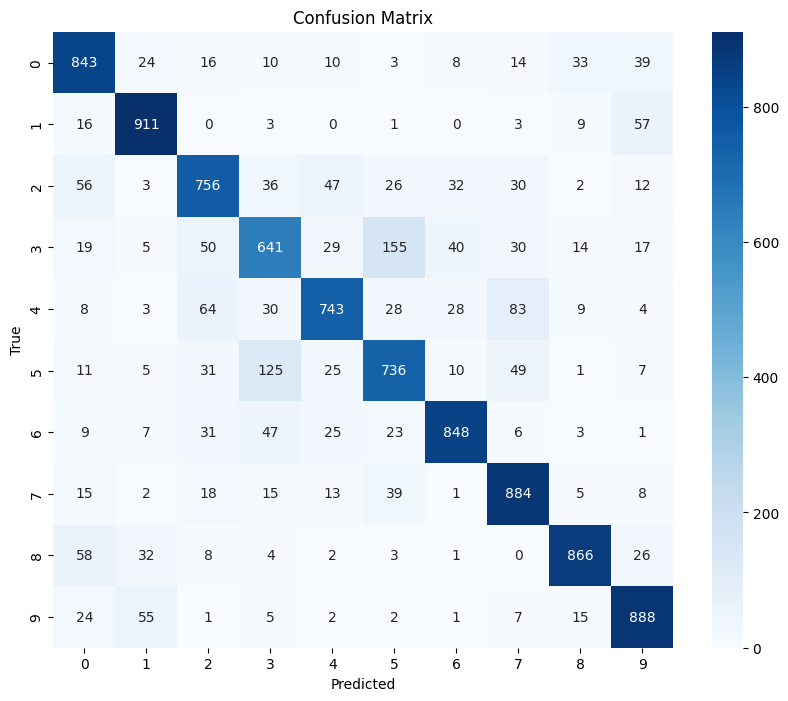

[[843  24  16  10  10   3   8  14  33  39]
 [ 16 911   0   3   0   1   0   3   9  57]
 [ 56   3 756  36  47  26  32  30   2  12]
 [ 19   5  50 641  29 155  40  30  14  17]
 [  8   3  64  30 743  28  28  83   9   4]
 [ 11   5  31 125  25 736  10  49   1   7]
 [  9   7  31  47  25  23 848   6   3   1]
 [ 15   2  18  15  13  39   1 884   5   8]
 [ 58  32   8   4   2   3   1   0 866  26]
 [ 24  55   1   5   2   2   1   7  15 888]]
              precision    recall  f1-score   support

           0     0.7960    0.8430    0.8188      1000
           1     0.8701    0.9110    0.8901      1000
           2     0.7754    0.7560    0.7656      1000
           3     0.6998    0.6410    0.6691      1000
           4     0.8292    0.7430    0.7838      1000
           5     0.7244    0.7360    0.7302      1000
           6     0.8751    0.8480    0.8614      1000
           7     0.7993    0.8840    0.8395      1000
           8     0.9049    0.8660    0.8850      1000
           9     0.8385    0

In [13]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Make predictions on the test set
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print(cm)

# Classification Report (per-class precision, recall, f1-score, support)
print(classification_report(all_labels, all_preds, digits=4))
